In [1]:
import copy
import os
import pickle
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process, time_rescale_transform
from gglm.utils import shift_array

from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues

from sptr.sptr import SpikeTrain

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

In [2]:
server_name = os.uname()[1]

In [3]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout2():
    ncols = 3
    r1, r2 = 2, 1
    nrows = 3 * r1
    fig = plt.figure(figsize=(10, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), rowspan=r1, colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
#     ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax31 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, ncols - 1), rowspan=r1, colspan=1)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), colspan=ncols - 1)
#     ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
#     ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
#     ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40)

## load data

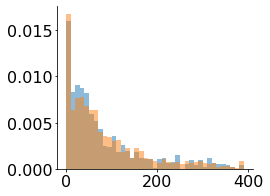

In [4]:
# path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
path = "./huk_p110509b_dots.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
t = np.arange(0, mask_spikes.shape[0], 1)
dt = 1

# offset = 100
# n_train = 100
# offset = 300
# n_train = 200
# n_val = 100

# offset = 400
# n_train = 200
# n_val = 200
files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'
with open(files_folder + 'idx_data.pk', "rb") as fit_file:
    dic = pickle.load(fit_file)
idx_train = dic['idx_train']
idx_val = dic['idx_val']

# idx = np.random.choice(mask_spikes.shape[1], size=n_train + n_val, replace=False)

st = SpikeTrain(t, mask_spikes)
mask_spikes_train = mask_spikes[:, idx_train]
# mask_spikes_train = mask_spikes[:, offset:offset + n_train]

n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)

mask_spikes_val = mask_spikes[:, idx_val]
n_spk_val = np.sum(mask_spikes_val)
fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_val = -bernoulli_log_likelihood_poisson_process(mask_spikes_val)
autocov_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)

st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
mean_isi_val = np.mean(isi_val)

bins_isi = np.arange(0, 400, 10)
fig, ax = plt.subplots()
ax.hist(isi_train, density=True, alpha=0.5, bins=bins_isi);
ax.hist(isi_val, density=True, alpha=0.5, bins=bins_isi);

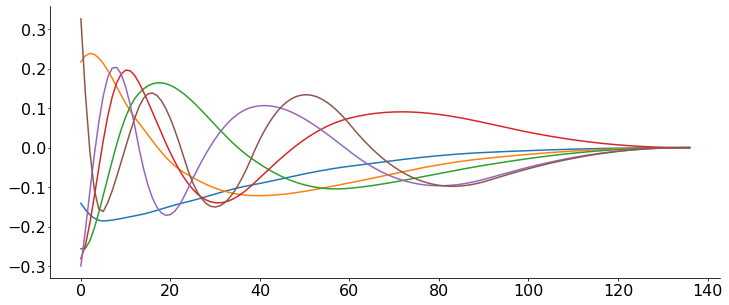

In [5]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

# n = 6
# last_peak = 400
# b = last_peak / 5

# n = 8
# last_peak = 300
# b = last_peak / 5

n = 6
last_peak = 60
b = last_peak / 5

peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b
t_ker = np.arange(0, mxt[-1] + dt, dt)
# t_ker = np.arange(0,)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

In [6]:
n_samples = 400

## contents <a name="contents"></a>  

[CIMMD](#cimmd)  

### CIMMD <a name="cimmd"></a>  
[contents](#contents)

In [7]:
with open(files_folder + 'ml.pk', "rb") as fit_file:
    dic_ml = pickle.load(fit_file)
eta_ml = KernelBasisValues(dic_ml['basis'], [0, dic_ml['basis'].shape[0]], 1, coefs=dic_ml['eta_coefs'])
glm_ml = TorchGLM(u0=dic_ml['u0_ml'], eta=eta_ml)
nll_normed_train_ml = dic_ml['nll_normed_train_ml']
nll_normed_val_ml = dic_ml['nll_normed_val_ml']
bins_ks = dic_ml['bins_ks']

r_train_dc_ml, r_val_dc_ml, r_fr_ml, mask_spikes_fr_ml = dic_ml['r_train_dc_ml'], dic_ml['r_val_dc_ml'], dic_ml['r_fr_ml'], dic_ml['mask_spikes_fr_ml']

st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
isi_fr_ml = st_fr_ml.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)
autocov_ml = np.mean(auto_covariance(mask_spikes_fr_ml, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)

z_ml_train, ks_ml_train = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml_train), bins=bins_ks)
z_cum_ml_train = np.append(0., np.cumsum(values) / np.sum(values))

z_ml_val, ks_ml_val = time_rescale_transform(dt, st_val.mask, r_val_dc_ml)
values, _ = np.histogram(np.concatenate(z_ml_val), bins=bins_ks)
z_cum_ml_val = np.append(0., np.cumsum(values) / np.sum(values))

In [8]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T_train = t[-1] - t[0] + t[1]
    mu_fr = np.mean(np.sum(mask_spikes_fr.double().numpy(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [11]:
from torch.nn.functional import conv1d

def phi_id(t, r):
    return r * 1000

def kernel_id(t, r1, r2):
    return torch.sum(r1[:, :, None] * 1000 * r2[:, None, :] * 1000, 0)

def phi_mean(t, r, **kwargs):
    return torch.mean(r, 0)[None, :] * 1000

def phi_sum(t, r):
    return torch.sum(r  * 1000, 0)[None, :]

padding_global = 250
def phi_autocov(t, r, model):
    T = len(t)
    eta = torch.log(r) - model.b
    padding = padding_global
#     offset = 0
#     limf = 150
    autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
    autocov = autocov[0, :, (padding-1):].T
#     autocov = autocov[0, :, (padding-1) + offset:(padding-1) + limf].T
    return autocov

def ker_autocov(t, r1, r2, model):
    T = len(t)
    eta1 = torch.log(r1) - model.b
    eta2 = torch.log(r2) - model.b
    padding = 150
    offset = 20
    limf = 150
    autocov1 = conv1d(eta1.T[None, :, :], eta1.T[:, None, :], padding=padding, groups=eta1.shape[1]) / T
    autocov1 = autocov1[0, :, (padding-1) + offset:(padding-1) + limf].T
    autocov2 = conv1d(eta2.T[None, :, :], eta2.T[:, None, :], padding=padding, groups=eta2.shape[1]) / T
    autocov2 = autocov2[0, :, (padding-1) + offset:(padding-1) + limf].T
#     print(autocov2.shape)
    gramian = torch.exp(-torch.mean((autocov1[:, :, None] - autocov2[:, None, :])**2, 0) / sd2)
#     print(gramian)
#     print(knwknw)
    return gramian
    
def kernel_expr(t, r1, r2, model):
#     gramian = torch.exp(-torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0) / sd2)
    gramian = torch.exp(-(torch.mean(r1, 0)[:, None] - torch.mean(r2, 0)[None, :])**2 / sd2)
    gramian += torch.exp(-(torch.mean(r1, 0)[:, None] - torch.mean(r2, 0)[None, :])**2 / 5e-5)
#     print(gramian)
#     print(kwnkw)
#     print(torch.sum((r1[:, :, None] - r2[:, None, :])**2, 0))
#     print(kwknwk)
#     print(gramian)
    return gramian

dic_ker_strings = {'phi_id': "<r,r'>", 'phi_mean': "mu_r * mu_r'", 'phi_sum': "sum_r * sum_r'", 
                   'kernel_expr': "exp(-sum((r-r')^2)/sd^2)", 'kernel_id': "<r,r'>", 'phi_autocov': "<g, g'>", 
                   'ker_autocov': "exp(-sum((r-r')^2)/sd^2)"}

dic_ker_name = {'phi_id': "canonical_dot", 'phi_mean': 'means_product', 'phi_sum': "sum_product", 
               'kernel_expr': "gaussian", 'kernel_id': "canonical_dot", 'phi_autocov': "autocov", 'ker_autocov': 'gauss_autocov'}

In [23]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, True, 1e-2, 1e0 # hermosa solucion. satura
# phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = None, kernel_id, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0

#phi autocov
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 1e3, True, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 5e3, True, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 1e4, True, 1e-2, 1e0

# phi mean
# phi, kernel, lam_mmd, lr, clip = phi_mean, None, 1e4, 1e-2, 1e0
# phi, kernel, lam_mmd, lr, clip, num_epochs = phi_mean, None, 5e4, 1e-2, 1e0, 400 # strong enough that fr doesnt jump during optimization

# ker gaussian
# phi, kernel, lam_mmd, biased, lr, clip, num_epochs, sd2 = None, kernel_expr, 5e3, True, 1e-2, 1e0, 500, 2e-6 # strong one but works
# phi, kernel, lam_mmd, biased, lr, clip = None, kernel_expr, 5e3, True, 1e-2, 1e0

# phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 2e4, True, 1e-2, 1e0

# padding 150
# phi, kernel, lam_mmd, biased, lr, clip, num_epochs = phi_autocov, None, 6.75e3, True, 1e-2, 1e0, 350 # matchea autocorr muy bien

# padding 150, offset 20, limf 150
# phi, kernel, lam_mmd, biased, lr, clip, num_epochs = phi_autocov, None, 8.25e3, True, 1e-2, 1e0, 350 # anda ponele

# padding 150, offset 0, limf 150
phi, kernel, lam_mmd, biased, lr, clip, num_epochs = phi_autocov, None, 8e3, True, 1e-2, 1e0, 350

beta0, beta1 = 0, 0
n_batch_fr = 200
n_metrics = 1

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()

mmdglm = CIMMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=True, score_term=False,
                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
z_cum_mmd_train = np.append(0., np.cumsum(values) / np.sum(values))

_, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)

nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
            dt * np.sum(r_dc_mmd_val[~st_val.mask]))
nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
# r_dc_mmd_val = r_dc_mmd_val * 1000

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 349 of 350 loss 6275.1384202523723
 took 381.134530544281 seconds 6.3522421757380165 minutes


In [28]:
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                           subtract_mean=False, stationary_signal=False, biased=False), 1)

nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
            dt * np.sum(r_dc_mmd_val[~st_val.mask]))
nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

# r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
# r_dc_mmd_val = r_dc_mmd_val * 1000

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')


 took 529.7513554096222 seconds 8.829189256827037 minutes


In [29]:
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
print(np.max(fr_mmd))

from scipy.stats import ks_2samp

fr_data = np.sum(mask_spikes_train, 0) / (dt * mask_spikes_train.shape[0]) * 1000
print(ks_2samp(fr_mmd, fr_data)) # smallest value 0.1358 for ker_gauss_autocov 8e3. new smalles 0.1055 for 4e3

15.702479338842977
KstestResult(statistic=0.139375, pvalue=0.0009120764184369357)


4.079912430618118e-10

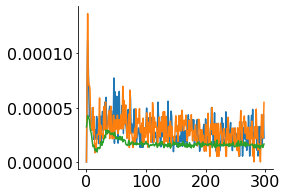

In [30]:
plt.plot(autocov_train[1:300])
plt.plot(autocov_val[1:300])
plt.plot(autocov_mmd[1:300])

sd2 = 1e-5
# print(kernel(torch.from_numpy(t), torch.from_numpy(r_dc_mmd_train), torch.from_numpy(r_fr_mmd), mmdglm))

phi_d = phi_autocov(torch.from_numpy(t), torch.from_numpy(r_dc_mmd_train), mmdglm)
phi_fr = phi_autocov(torch.from_numpy(t), torch.from_numpy(r_fr_mmd), mmdglm)

argf = 150
np.mean((autocov_val[1:argf] - autocov_mmd[1:argf])**2)

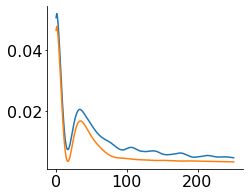

In [31]:
phi_d_mean = torch.mean(phi_d, 1).detach()
phi_fr_mean = torch.mean(phi_fr, 1).detach()

plt.plot(phi_d_mean)
plt.plot(phi_fr_mean)

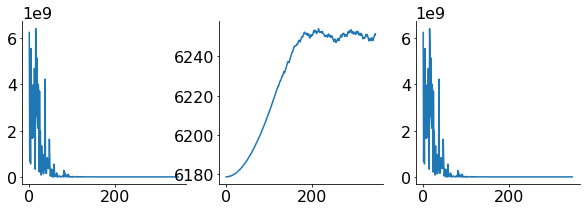

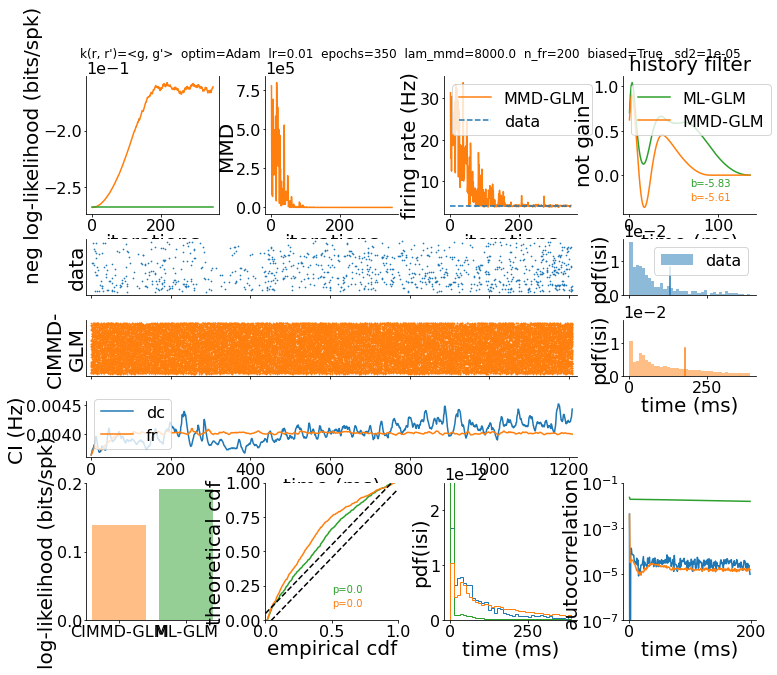

In [32]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax2.plot(nll_train)
ax3.plot((loss_mmd - nll_train))
# ax3.set_ylim(0, 1e4)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
fig.suptitle(title, fontsize=12, y=0.92)

ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
# ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('CIMMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax40.bar(0, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(1, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
# ax40.legend()
ax40.set_ylabel('log-likelihood (bits/spk)')
ax40.set_xticks([0, 1])
ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

# ax40.set_ylabel('log-likelihood (bits/spk)')

ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

lw = 1
# ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
ax42.set_ylim(0, 0.025)
ax42.set_ylabel('pdf(isi)')
ax42.set_xlabel('time (ms)')
ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax42.legend()
# y1 = ax42.get_ylim()[1] / 2
# ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax42.tick_params(axis='both', labelbottom=False)

argf = 200
ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
ax43.set_ylim(1e-7, 1e-1)
ax43.set_yscale('log')
myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

In [33]:
fig_name

'cimmd_autocov_lammmd8000.0biasedTrue_epochs350_lr0.01_1.pdf'

In [34]:
fig_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
           '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

ii = 1
while fig_name + '_' + str(ii) + '.pdf' in list_files:
    ii += 1
file_name = fig_name + '_' + str(ii) + '.pk'
fig_name += '_' + str(ii) + '.pdf'

fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

dic = dict(idx_train=idx_train, idx_val=idx_val, padding=padding_global, basis=basis, u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
           metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)
    
# dic = dict(n_train=n_train, n_val=n_val, mmd_ker='model_based', ker_name=ker_name, lam_mmd=lam_mmd, biased=biased, lr=lr, 
#            clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_train[-1], 
#            metrics_mmd=metrics_mmd['mmd'][-1])
# _df = pd.DataFrame.from_dict(dic, orient='index').T

# df = pd.read_json('/home/diego/storage/generative-glm/experiments/figure4/summary.json')
# df = df.append(_df, ignore_index=True)
# df.to_json('/home/diego/storage/generative-glm/experiments/figure4/summary.json')

In [20]:
fig_name

'cimmd_autocov_lammmd10000.0biasedTrue_epochs350_lr0.01_3.pdf'

In [34]:
df['nll_train'] = df['nll_train'].astype(float)
df.groupby(['ker_name', 'lam_mmd'])['nll_train'].mean()

ker_name     lam_mmd
phi_autocov  5000       7226.077304
             10000      7242.107616
phi_mean     5000       7219.140934
             10000      7228.631197
Name: nll_train, dtype: float64

In [ ]:
for ii in range(20):
    # phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, True, 1e-2, 1e0 # hermosa solucion. satura
    # phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 1e4, True, 1e-2, 1e0 # nice one
    # phi, kernel, lam_mmd, biased, lr, clip = phi_id, None, 1e-2, False, 1e-2, 1e0
    # phi, kernel, lam_mmd, biased, lr, clip = None, kernel_id, 1e-2, False, 1e-2, 1e0
    # phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0

    #phi autocov
    phi, kernel, lam_mmd, biased, lr, clip, num_epochs = phi_autocov, None, 4e3, True, 1e-2, 1e0, 300

    # phi mean
#     phi, kernel, lam_mmd, lr, clip = phi_mean, None, 2e4, 1e-2, 1e0
    # phi, kernel, lam_mmd, lr, clip = phi_mean, None, 5e4, 1e-2, 1e0 # strong enough that fr doesnt jump during optimization

    # ker gaussian
    # phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0 # strong one but works
    # phi, kernel, lam_mmd, biased, lr, clip = None, kernel_expr, 5e3, True, 1e-2, 1e0

    sd2 = 2e-2

    beta0, beta1 = 0, 0
    n_batch_fr = 100
    n_metrics = 1

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()

    # eta0_scaled = glm.eta.copy()
    # eta0_scaled.coefs = eta0_scaled.coefs * 0.1
    # mmdglm = CIMMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

    mmdglm = CIMMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=True, score_term=False,
                                                   n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)
    autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_mmd_val[~st_val.mask]))
    nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
    z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
    r_dc_mmd_val = r_dc_mmd_val * 1000

    time1 = time.time()
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
    ax1.plot(loss_mmd)
    ax2.plot(nll_train)
    ax3.plot((loss_mmd - nll_train))
    # ax3.set_ylim(0, 1e4)

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    # ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
    ax42.set_ylim(0, 0.025)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
    ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    ax43.set_ylim(1e-7, 1e-1)
    ax43.set_yscale('log')
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    fig_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
               '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

    ii = 1
    while fig_name + '_' + str(ii) + '.pdf' in list_files:
        ii += 1
    file_name = fig_name + '_' + str(ii) + '.pk'
    fig_name += '_' + str(ii) + '.pdf'

    fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

    dic = dict(offset=offset, n_train=n_train, n_val=n_val, basis=basis, u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
               metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    dic = dict(offset=offset, n_train=n_train, n_val=n_val, mmd_ker='model_based', ker_name=ker_name, lam_mmd=lam_mmd, biased=biased, lr=lr, 
               clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_train[-1], 
               metrics_mmd=metrics_mmd['mmd'][-1])
    _df = pd.DataFrame.from_dict(dic, orient='index').T

    df = pd.read_json('/home/diego/storage/generative-glm/experiments/figure4/summary.json')
    df = df.append(_df, ignore_index=True)
    df.to_json('/home/diego/storage/generative-glm/experiments/figure4/summary.json')

 epoch 299 of 300 loss 5240.633317306379
 took 279.95618867874146 seconds 4.665936477979025 minutes
 epoch 60 of 300 loss 5345.3244040043195

In [55]:
# _df = pd.DataFrame.from_dict(dic, orient='index').T
# _df.to_json('/home/diego/storage/generative-glm/experiments/figure4/summary.json')

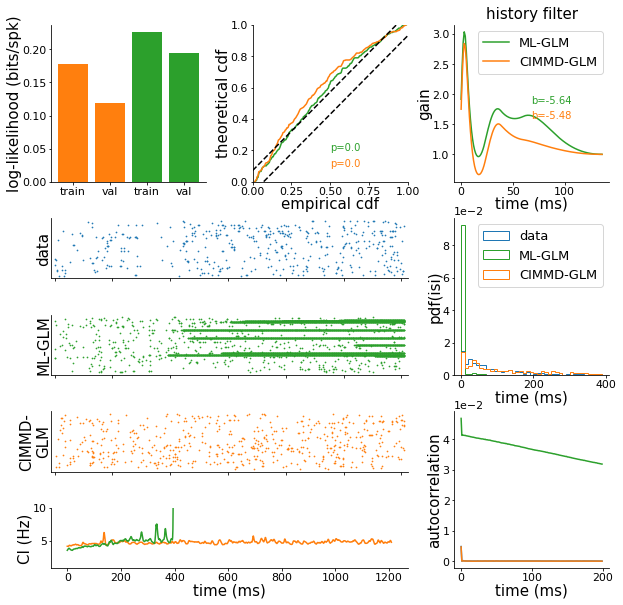

In [36]:
fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40) = plot_layout2()
fig.subplots_adjust(hspace=0.6, wspace=0.3)
# fig.suptitle('Monkey-PMv', fontsize=16, y=0.92)

ax00.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(1, -nll_normed_val_mmd, color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.bar(3, -nll_normed_val_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.set_ylabel('log-likelihood (bits/spk)')
ax00.set_xticks([0, 1, 2, 3])
# ax00.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])
ax00.set_xticklabels(['train', 'val', 'train', 'val'])

ax01.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
ax01.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax01.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
ax01.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
myplt.set_labels(ax01, xlabel='empirical cdf', ylabel='theoretical cdf')
ax01.set_xlim(0, 1); ax01.set_ylim(0, 1)
ax01.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax01.transAxes)
ax01.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax01.transAxes)

glm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
ax02.legend()
# ax02.set_ylim(-0.4, 0.2)

st_val.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

st_fr_ml.plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

lw = 1
ax11.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
ax11.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
ax11.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
ax11.set_ylabel('pdf(isi)')
ax11.set_xlabel('time (ms)')
ax11.legend()
ax11.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_fr_mmd.plot(ax=ax30, ms=0.7, color=palette['mmd'])
ax30.tick_params(axis='both', labelbottom=False, labelleft=False)
ax30.set_yticks([])
ax30.set_ylabel('CIMMD-\nGLM')

argf = 200
ax31.plot(autocov_train[:argf], color=palette['d'], label='data')
ax31.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
ax31.plot(autocov_mmd[:argf], color=palette['mmd'], label='CIMMD-GLM')
# ax31.set_ylim(0, 5e-3)
myplt.set_labels(ax31, xlabel='time (ms)', ylabel='autocorrelation')
ax31.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
ax40.plot(t, np.mean(r_fr_mmd, 1), alpha=alpha, color=palette['mmd'], label='fr')
ax40.plot(t, np.mean(r_fr_ml, 1), alpha=alpha, color=palette['ml'], label='fr')
# ax40.legend()
ax40.set_ylim(0.8, 1e1)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='CI (Hz)')

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)

In [41]:
# # phi, kernel, lam_mmd, lr, clip = phi_id, None, 5e1, 1e-2, 1e0 # nice solution

# # phi, kernel, lam_mmd, lr, clip = phi_sum, None, 1e2, 1e-2, 1e0

# phi, kernel, lam_mmd, lr, clip = None, kernel_expr, 1e5, 1e-2, 1e0
# sd2 = 1e-2

# beta0, beta1 = 0, 0
# n_batch_fr = 200
# biased = False
# num_epochs = 125

# time0 = time.time()
# u00 = glm.u0
# eta0 = glm.eta.copy()

# # eta0_scaled = glm.eta.copy()
# # eta0_scaled.coefs = eta0_scaled.coefs * 0.1
# # mmdglm = CIMMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

# mmdglm = CIMMDGLM(u0=u00, eta=eta0)
# optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

# loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, log_likelihood=True, 
#                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
#                                               verbose=True, metrics=fun_metrics_mmd, n_metrics=1)
# loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
# metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
# iterations_mmd = np.arange(1, num_epochs + 1, 1)

# _, r_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
# _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
# st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
# isi_fr_mmd = st_fr_mmd.isi_distribution()
# mean_isi_fr_mmd = np.mean(isi_fr_mmd)
# r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

# time1 = time.time()
# print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')
# # phi.__name__, kernel, lam_mmd, num_epochs, lr, clip, beta0, beta1, n_batch_fr, lam_mmd, biased
# # optim.__class__.__name__, u00, eta0, mmdglm.u0, mmdglm.eta, 

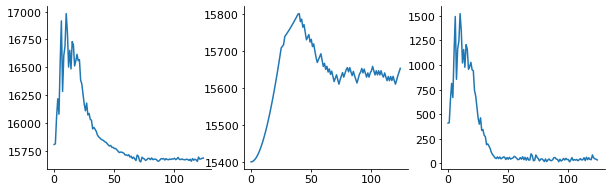

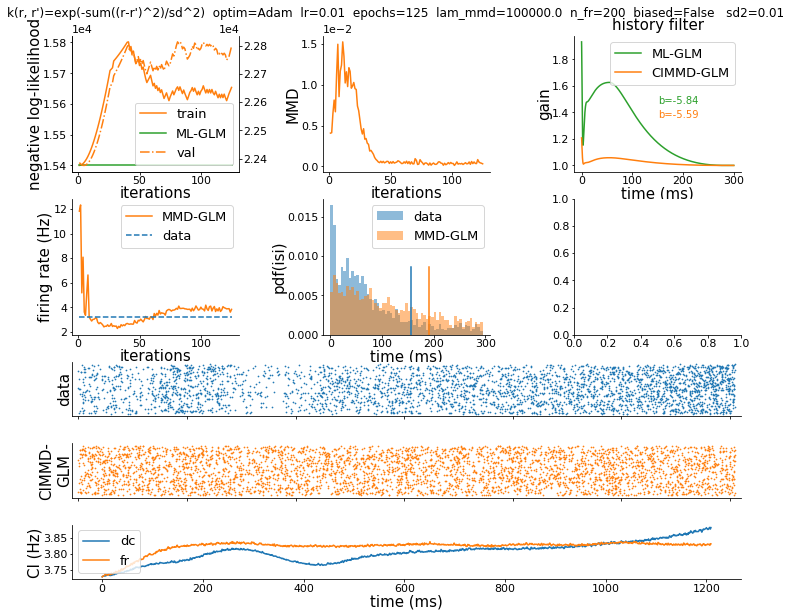

In [238]:
# for key, val in metrics_mmd.items():
#     metrics_mmd[key] = np.array(val)

# if phi is not None:
#     ker_name = phi.__name__
# else:
#     ker_name = kernel.__name__
    
# title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
#      + '  epochs=' + str(num_epochs) + \
#        '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)
    
# r1, r2 = 2, 1
# ncols = 3

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
# ax1.plot(loss_mmd)
# ax2.plot(nll_train)
# ax3.plot(loss_mmd - nll_train)

# # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(title, fontsize=12, y=0.92)
# ax00 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 0), rowspan=r1)
# ax01 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 1), rowspan=r1)
# ax02 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 2), rowspan=r1)
# ax10 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 0), rowspan=r1)
# ax11 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 1), rowspan=r1)
# ax12 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 2), rowspan=r1)
# ax2 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1, 0), colspan=ncols)
# ax3 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + r2, 0), colspan=ncols)
# ax4 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + 2*r2, 0), colspan=ncols)

# ax00.plot(iterations_mmd, nll_train, '-', label='train', color=palette['mmd'])
# ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_train[0], nll_train[0]], '-', label='ML-GLM', color=palette['ml'])
# ax00.spines['right'].set_visible(True)
# ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.plot(iterations_mmd[0], nll_train[0], '-.', label='val', color=palette['mmd'])
# ax00.legend()
# ax00twin = ax00.twinx()
# ax00twin.plot(iterations_mmd, metrics_mmd['nll_val'], '-.', label='val', color=palette['mmd'])
# myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')
# ax00twin.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ax01.plot(iterations_mmd, metrics_mmd['mmd'], label='CIMMD-GLM', color=palette['mmd'])
# # ax01.set_ylim(-1e-1, np.median(metrics_mmd['mmd'][-10:]) * 5)
# ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

# glm.eta.plot(ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
# mmdglm.eta.plot(ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
# myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
# ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
# ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
# ax02.legend()

# ax10.plot(iterations_mmd, metrics_mmd['fr_fr'], label='MMD-GLM', color=palette['mmd'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
# myplt.set_labels(ax10, xlabel='iterations', ylabel='firing rate (Hz)')
# ax10.legend()

# bins = np.arange(0, 300, 5)
# ax11.hist(isi_val, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
# ax11.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax11.legend()
# y1 = ax11.get_ylim()[1] / 2
# ax11.plot([mean_isi_val, mean_isi_val], [0, y1], '-', color=palette['d'])
# ax11.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
# myplt.set_labels(ax11, xlabel='time (ms)', ylabel='pdf(isi)')

# # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# # st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
# st_val.plot(ax=ax2, ms=0.7, color=palette['d'])
# ax2.tick_params(axis='both', labelbottom=False, labelleft=False)
# ax2.set_yticks([])
# ax2.set_ylabel('data')

# st_fr_mmd.plot(ax=ax3, ms=0.7, color=palette['mmd'])
# ax3.tick_params(axis='both', labelbottom=False, labelleft=False)
# ax3.set_yticks([])
# ax3.set_ylabel('CIMMD-\nGLM')

# ax4.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
# ax4.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# ax4.legend()
# myplt.set_labels(ax4, xlabel='time (ms)', ylabel='CI (Hz)')

# fig.subplots_adjust(hspace=0.5, wspace=0.5)
# # fig.tight_layout()

# fig_name = dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

# import os
# list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/huk/')

# ii = 1
# while fig_name + '_' + str(ii) + '.pdf' in list_files:
#     ii += 1
# fig_name += '_' + str(ii) + '.pdf'

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/huk/' + fig_name, transparent=True)